In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import time
import numpy as np
import torch
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
from torchsummary import summary
import torchvision.models as models
import tensorflow as tf
from skimage.transform import resize
import torch.nn as nn
from torchvision import transforms
import os
from typing import Any
from torchvision.transforms import Resize
import torch
import torch.nn as nn
from cv2 import cv2

# Raw data
(raw_x_train, raw_y_train), (raw_x_test, raw_y_test) = tf.keras.datasets.mnist.load_data()

def normalize(picture):
    normalizedPicture = (picture - np.min(picture)) / (np.max(picture) - np.min(picture))
    return normalizedPicture

# Prepare raw data for use in each CNN 
def prepare_data(x_train, y_train, x_test, y_test):
    x_train = normalize(x_train)
    x_test  = normalize(x_test)
    x_train = torch.tensor(x_train).float().cuda()
    y_train = torch.tensor(y_train).float().cuda()
    x_test  = torch.tensor(x_test).float().cuda()
    y_test  = torch.tensor(y_test).float().cuda()
    return    (x_train, y_train, x_test, y_test)


11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
# Compare Custom model to linear classifier

class LinearClassifier(torch.nn.Module):
    def __init__(self, input_dim=784, output_dim=10):
        super(LinearClassifier, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)
  
    def forward(self, x):
        return self.linear(x)

# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
class CustomCNN(nn.Module):
    def __init__(self, input_dim=28*28, output_dim=10):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 10, 5)
        self.conv3 = nn.Conv2d(10, 20, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.linear = nn.Linear(20, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        return self.linear(x)

#https://pytorch.org/vision/stable/_modules/torchvision/models/alexnet.html
__all__ = ["AlexNet", "alexnet"]

model_urls = {
    "alexnet": "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth",
}

class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 10, dropout: float = 0.5) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
# Train linear classifier

PATH = '/content/drive/Shareddrives/Compv5/FinalProject/'

# Prepare data
x_train, y_train, x_test, y_test = prepare_data(raw_x_train, raw_y_train, raw_x_test, raw_y_test)
x_train = x_train.view(-1, 28*28)
x_test  = x_test.view(-1, 28*28)

if os.path.exists(PATH + 'lc.pth'):
    lc = LinearClassifier().cuda()
    lc.load_state_dict(torch.load(PATH + 'lc.pth'))
    lc.eval()

else:
    beg = time.time()

    lc = LinearClassifier().cuda()
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(lc.parameters(), lr=0.01)
    all_loss  = []

    for epoch in range(1000):
        output = lc(x_train)
        loss = criterion(output, y_train.long())
        all_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    torch.save(lc.state_dict(), PATH + 'lc.pth')

    end = time.time()

    total1 = end - beg
    
    print(f'Total time: {total1} seconds.')

In [ ]:
# Train custom classifier

PATH = '/content/drive/Shareddrives/Compv5/FinalProject/'

# Prepare data
x_train, y_train, x_test, y_test = prepare_data(raw_x_train, raw_y_train, raw_x_test, raw_y_test)

# Add extra dimension (index 1): ([60000, 28, 28]) -> ([60000, 1, 28, 28])
x_train = x_train.unsqueeze(1)

# Split x into batches for training


beg = time.time()

cnn       = CustomCNN().cuda()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.01)
all_loss  = []

for epoch in range(1000):
    for i in range(x_train.shape[0] // 500):
        output = cnn(x_train[i*500:(i+1)*500])
        loss = criterion(output, y_train.long()[i*500:(i+1)*500])
        all_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

end = time.time()
total1 = end - beg

print(f'Total time: {total1} seconds.')

Total time: 1402.64315366745 seconds.


In [ ]:
# Train AlexNet. Reduced dataset to 5000 training, 1000 testing. Memory constraints.

PATH = '/content/drive/Shareddrives/Compv5/FinalProject/'

x_train, y_train, x_test, y_test = prepare_data(raw_x_train, raw_y_train, raw_x_test, raw_y_test)
x_train = x_train.unsqueeze(1)[:5000]
x_test  = x_test.unsqueeze(1)[:1000]

resize  = Resize((224, 224))
x_train = resize(x_train)
x_test  = resize(x_test)

if os.path.exists(PATH + 'AlexNet.pth'):
    an = AlexNet().cuda()
    an.load_state_dict(torch.load(PATH + 'AlexNet.pth'))
    an.eval()

else:
    beg = time.time()

    an        = AlexNet().cuda()
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(an.parameters(), lr=0.01)
    all_loss  = []

    for epoch in range(100):
        for i in range(x_train.shape[0] // 10):
            output = an(x_train[i*10:(i+1)*10])
            loss = criterion(output, y_train.long()[i*10:(i+1)*10])
            all_loss.append(loss.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

    end = time.time()

    torch.save(an.state_dict(), PATH + 'AlexNet.pth')

    total1 = end - beg

    print(f'Total time: {total1} seconds.')


In [ ]:
# Linear Classifier performance
lc_x_train, lc_y_train, lc_x_test, lc_y_test = prepare_data(raw_x_train, raw_y_train, raw_x_test, raw_y_test)
lc_x_test = lc_x_test.view(-1, 28*28)
lc_predictions  = lc(lc_x_test)
lc_pred_classes = lc_predictions.max(1).indices
lc_accuracy = ((lc_pred_classes == lc_y_test).sum().item() / lc_pred_classes.shape[0]) * 100
print(f'Linear classifier accuracy: {lc_accuracy:.2f}%')

# CNN Performance
cnn_x_train, cnn_y_train, cnn_x_test, cnn_y_test = prepare_data(raw_x_train, raw_y_train, raw_x_test, raw_y_test)
cnn_x_test  = cnn_x_test.unsqueeze(1)
cnn_predictions  = cnn(cnn_x_test)
cnn_pred_classes = cnn_predictions.max(1).indices
cnn_accuracy = ((cnn_pred_classes == cnn_y_test).sum().item() / cnn_pred_classes.shape[0]) * 100
print(f'CNN Accuracy: {cnn_accuracy:.2f}%')

# AlexNet performance
alex_x_train, alex_y_train, alex_x_test, alex_y_test = prepare_data(raw_x_train, raw_y_train, raw_x_test, raw_y_test)
alex_x_test = alex_x_test.unsqueeze(1)[:1000]
alex_y_test = alex_y_test[:1000]
resize  = Resize((224, 224))
alex_x_test  = resize(alex_x_test)
alex_predictions = an(alex_x_test)
alex_pred_classes = alex_predictions.max(1).indices
alex_accuracy = ((alex_pred_classes == alex_y_test).sum().item() / alex_pred_classes.shape[0]) * 100
print(f'AlexNet accuracy: {alex_accuracy:.2f}%')


Linear classifier accuracy: 86.99%
CNN Accuracy: 98.16%
AlexNet accuracy: 96.80%


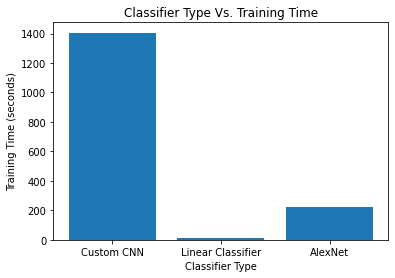

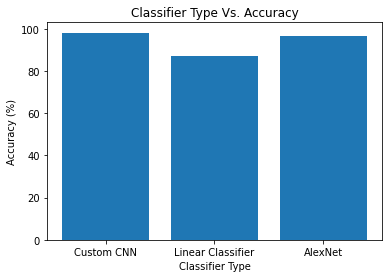

In [ ]:
PATH = '/content/drive/Shareddrives/Compv5/FinalProject/'
names = []
times = []
accs  = []
with open(PATH + 'data.csv', 'r') as file:
    for line in file:
        data = line.rsplit(',' or '\n')
        names.append(data[0].rstrip())
        times.append(float(data[1].rstrip()))
        accs.append(float(data[2].rstrip()))

plt.bar(names, times)
plt.title('Classifier Type Vs. Training Time')
plt.xlabel('Classifier Type')
plt.ylabel('Training Time (seconds)')
plt.savefig(PATH + 'TrainingTime.png')
plt.show()

plt.bar(names, accs)
plt.title('Classifier Type Vs. Accuracy')
plt.xlabel('Classifier Type')
plt.ylabel('Accuracy (%)')
plt.savefig(PATH + 'Accuracy.png')
plt.show()

In [ ]:
!jupyter nbconvert --to html "/content/drive/Shareddrives/Compv5/FinalProject/FinalProject.ipynb"

[NbConvertApp] Converting notebook /content/drive/Shareddrives/Compv5/FinalProject/FinalProject.ipynb to html
[NbConvertApp] Writing 351750 bytes to /content/drive/Shareddrives/Compv5/FinalProject/FinalProject.html
